# 1. Эксперимент #

In [1]:
import threading

total = []
 
def doubler(number):
    """
    A function that can be used by a thread
    """
    
    global total
    total.append(i)
    
    print(threading.currentThread().getName() + '\n')
 
if __name__ == '__main__':
    for i in range(5):
        my_thread = threading.Thread(target=doubler, args=(i,))
        my_thread.start()
        
    print(total)

Thread-6

Thread-7

Thread-8

Thread-9

Thread-10

[0, 1, 2, 3, 4]


Цель работы - научиться применять нейронные сети для задачи классификации. Набор данных генерируется методом Монте Карло. Каждый класс содержит два признака - время замедления и колличество столкновений.

## Блок нейтронной физики ##

In [2]:
import pandas as pd
import random as rd
import math as math
import scipy.constants as const # Модуль физико-математических констант

# отключим предупреждения Anaconda
import warnings
warnings.simplefilter('ignore')

N_A = const.Avogadro

### Функция жизни нейтрона: ###

In [3]:
# Для одинаковой генерации данных
rd.seed(42)

def life_of_neutron(Ein, Eout, dens, A1, A2, Mol_m, Sigma, alpha_1, alpha_2, sigma_1, sigma_2, x1, x2):
    
    Energy = Ein
    colision = 0 # Число столкновений
    time = 0 # Время полета
    a = 0 # Угол полета
    b = 0 # Изменение угла полета
    l = 0 # Длина пролета
    V = 0 # Скорость
    elder = 0 #Возраст
    while Energy > Eout: #Пока энергия нейтрона лежит в области > ... ЭВ
        l = -1*math.log(rd.random())/Sigma/100 # В метрах
        V = (2*Energy*1.6*(10**(-19))/(1.6749*10**(-27)))**0.5 # В м/с
        time += l/V
        colision += 1
        
        #Разыгрывание на каком ядре произошло рассеяние
        x = rd.random()
        if x < (x1*sigma_1/(x1*sigma_1 + x2*sigma_2)):# Рассеяние на первом ядре
            E1 = Energy
            E2 = Energy*alpha_1
            Energy = rd.uniform(E1, E2)
            b = math.acos

            
        else:# Рассеяние на втором ядре
            E1 = Energy
            E2 = Energy*alpha_2
            Energy = rd.uniform(E1, E2)

    return colision, time

### Входные данные по материалам: ###

In [4]:
df = pd.DataFrame({'Material': ['Water', 'Heavy Plexiglass', 'Heavy Water'],
                   'Density g/cm^3': [1.0, 1.6, 1.1],
                    'A_1' : [1, 12, 2],
                    'A_2' : [16, 2, 16],
                    'Molar mass g/mol' : [18, 28, 20],
                    'Chemical formula' : ['H2O', 'C2D2', 'D2O'],
                    'sigma_1 b' : [30.0, 4.9, 3.5],
                    'sigma_2 b' : [4.0, 3.5, 4.0],
                    'x1' : [2, 2, 2],
                    'x2' : [1, 2, 1],
                    
              })

df

,Material,Density g/cm^3,A_1,A_2,Molar mass g/mol,Chemical formula,sigma_1 b,sigma_2 b,x1,x2
0,Water,1.0,1,16,18,H2O,30.0,4.0,2,1
1,Heavy Plexiglass,1.6,12,2,28,C2D2,4.9,3.5,2,2
2,Heavy Water,1.1,2,16,20,D2O,3.5,4.0,2,1


### Расчет макросечения: ###

In [5]:
df['\u03A3, 1/cm'] = 0.0
for k in df.index:
    df['Σ, 1/cm'][k] = (df['x1'][k]*df['sigma_1 b'][k]+df['x2'][k]*df['sigma_2 b'][k]
                       )*N_A*df['Density g/cm^3'][k]/df['Molar mass g/mol'][k]/10**(24)
display(df)

,Material,Density g/cm^3,A_1,A_2,Molar mass g/mol,Chemical formula,sigma_1 b,sigma_2 b,x1,x2,"Σ, 1/cm"
0,Water,1.0,1,16,18,H2O,30.0,4.0,2,1,2.141206
1,Heavy Plexiglass,1.6,12,2,28,C2D2,4.9,3.5,2,2,0.578126
2,Heavy Water,1.1,2,16,20,D2O,3.5,4.0,2,1,0.364340


### Расчет ступеньки замедления: ###

In [6]:
df['\u0251_1'] = 0.0
df['\u0251_2'] = 0.0
for k in df.index:
    df['\u0251_1'][k] = ((df['A_1'][k]-1)/(df['A_1'][k]+1))**2
    df['\u0251_2'][k] = ((df['A_2'][k]-1)/(df['A_2'][k]+1))**2
display(df)

,Material,Density g/cm^3,A_1,A_2,Molar mass g/mol,Chemical formula,sigma_1 b,sigma_2 b,x1,x2,"Σ, 1/cm",ɑ_1,ɑ_2
0,Water,1.0,1,16,18,H2O,30.0,4.0,2,1,2.141206,0.000000,0.778547
1,Heavy Plexiglass,1.6,12,2,28,C2D2,4.9,3.5,2,2,0.578126,0.715976,0.111111
2,Heavy Water,1.1,2,16,20,D2O,3.5,4.0,2,1,0.364340,0.111111,0.778547


### Создание DataFrame для записи данных ###

In [7]:
df1 = pd.DataFrame({'time, 10^(-5) c': [],
                   'colisions': [],
                    'Material' : [],
                    'target' : [] 
              })
df1

,"time, 10^(-5) c",colisions,Material,target


### Эксперимент методом Монте-Карло ###

In [8]:
Estart = 1_000_000 #1Мэв
Eend = 1 #1 Эв
Colision = [0, 0, 0, 0]
Time = [0, 0, 0, 0]
number_of_event = 300
counter = 0 # Счетчик для записи в DataFrame
for k in df.index: #Цикл по материалам
    for i in range(0, number_of_event*(k+1)): #Колличество событий для каждого материала
        colision, time = life_of_neutron(Estart, Eend, df['Density g/cm^3'][k],
                                          df['A_1'][k], df['A_2'][k],
                                          df['Molar mass g/mol'][k], df['Σ, 1/cm'][k],
                                          df['ɑ_1'][k], df['ɑ_2'][k],
                                          df['sigma_1 b'][k], df['sigma_2 b'][k],
                                          df['x1'][k], df['x2'][k],)
        df1.loc[counter] = {'Material': df['Material'][k], 'time, 10^(-5) c': time*100_000, 'colisions': colision, 'target': k}
        Colision[k]+=colision
        Time[k]+=time
        counter+=1




In [9]:
for k in df.index:
    Colision[k] = Colision[k]/number_of_event/(k+1)
    Time[k] = Time[k]/number_of_event/(k+1)
    
for k in df.index:
    print(df['Material'][k])
    print(Colision[k])
    print(Time[k])

Water
15.643333333333333
6.787573276044247e-07
Heavy Plexiglass
35.90833333333333
6.268212392367504e-06
Heavy Water
28.513333333333335
7.811704616661977e-06


In [10]:
df1.to_csv("neutron_moderator.csv", index = False)

In [11]:
df2 = pd.read_csv("neutron_moderator.csv")
df2.head(2)

,"time, 10^(-5) c",colisions,Material,target
0,0.060134,18.0,Water,0.0
1,0.015265,11.0,Water,0.0


# 2. Первичный анализ данных с помощью Pandas #

Посмотрим, что представляют собой полученные данные

In [12]:
df1.head()

,"time, 10^(-5) c",colisions,Material,target
0,0.060134,18.0,Water,0.0
1,0.015265,11.0,Water,0.0
2,0.058799,17.0,Water,0.0
3,0.047027,14.0,Water,0.0
4,0.018141,10.0,Water,0.0


Сколько строк и столбцов

In [13]:
df1.shape

(1800, 4)

Общая информация

In [14]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1800 entries, 0 to 1799
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   time, 10^(-5) c  1800 non-null   float64
 1   colisions        1800 non-null   float64
 2   Material         1800 non-null   object 
 3   target           1800 non-null   float64
dtypes: float64(3), object(1)
memory usage: 70.3+ KB


In [15]:
df1['colisions'] = df1['colisions'].astype('int64')
df1['target'] = df1['target'].astype('int64')
df1['time, 10^(-5) c'] = df1['time, 10^(-5) c'].astype('float64')

df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1800 entries, 0 to 1799
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   time, 10^(-5) c  1800 non-null   float64
 1   colisions        1800 non-null   int64  
 2   Material         1800 non-null   object 
 3   target           1800 non-null   int64  
dtypes: float64(1), int64(2), object(1)
memory usage: 70.3+ KB


Распределение числовых параметров

In [16]:
df1.describe()

,"time, 10^(-5) c",colisions,target
count,1800.000000,1800.000000,1800.000000
mean,0.610838,28.833333,1.333333
std,0.430306,9.030121,0.745563
min,0.005600,6.000000,0.000000
25%,0.297471,23.000000,1.000000
50%,0.555621,29.000000,1.500000
75%,0.853301,35.000000,2.000000
max,4.030266,59.000000,2.000000


Изменение типа данных с учетом значений

In [17]:
df1['colisions'] = df1['colisions'].astype('int8')
df1['target'] = df1['target'].astype('int8')
df1['time, 10^(-5) c'] = df1['time, 10^(-5) c'].astype('float64')

df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1800 entries, 0 to 1799
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   time, 10^(-5) c  1800 non-null   float64
 1   colisions        1800 non-null   int8   
 2   Material         1800 non-null   object 
 3   target           1800 non-null   int8   
dtypes: float64(1), int8(2), object(1)
memory usage: 45.7+ KB


Описание не числовых типов данных

In [18]:
df1.describe(include=['object'])

,Material
count,1800
unique,3
top,Heavy Water
freq,900


Распределение данных по целевой переменной

In [19]:
df1['target'].value_counts()

2    900
1    600
0    300
Name: target, dtype: int64

In [20]:
df1['target'].value_counts(normalize=True)

2    0.500000
1    0.333333
0    0.166667
Name: target, dtype: float64

Сортировка по убыванию colisions

In [21]:
df1 = df1.sort_values(by='colisions', ascending=False)
df1.head()

,"time, 10^(-5) c",colisions,Material,target
791,0.729316,59,Heavy Plexiglass,1
680,1.211173,58,Heavy Plexiglass,1
486,2.111941,57,Heavy Plexiglass,1
377,1.457662,56,Heavy Plexiglass,1
807,0.532553,55,Heavy Plexiglass,1


Сортировка по убыванию time, 10^(-5) c

In [22]:
df1 = df1.sort_values(by='time, 10^(-5) c', ascending=False)
df1.head()

,"time, 10^(-5) c",colisions,Material,target
1762,4.030266,40,Heavy Water,2
1246,2.830374,37,Heavy Water,2
1267,2.784204,31,Heavy Water,2
907,2.492663,42,Heavy Water,2
1013,2.417235,29,Heavy Water,2


Сортировка по возрастанию colisions

In [23]:
df1 = df1.sort_values(by='colisions', ascending=True)
df1.head()

,"time, 10^(-5) c",colisions,Material,target
280,0.013819,6,Water,0
129,0.039810,6,Water,0
178,0.019329,7,Water,0
61,0.017364,7,Water,0
44,0.017380,7,Water,0


In [24]:
import numpy as np

Максимум по каждому признаку

In [25]:
df1.apply(np.max)

time, 10^(-5) c    4.03027
colisions               59
Material             Water
target                   2
dtype: object

Группировка данных

In [26]:
columns_to_show = ['time, 10^(-5) c', 'colisions']
df1.groupby(['target'])[columns_to_show].describe(percentiles=[0.25, 0.50, 0.99])

time, 10^(-5) c                                                    \
                 count      mean       std       min       25%       50%   
target                                                                     
0                300.0  0.067876  0.052758  0.005600  0.031281  0.053436   
1                600.0  0.626821  0.300871  0.122030  0.386285  0.576300   
2                900.0  0.781170  0.426260  0.047984  0.472239  0.689330   

                           colisions                                         \
             99%       max     count       mean       std   min   25%   50%   
target                                                                        
0       0.236044  0.388820     300.0  15.643333  3.967610   6.0  13.0  16.0   
1       1.390077  2.111941     600.0  35.908333  7.160217  16.0  31.0  35.0   
2       1.994400  4.030266     900.0  28.513333  5.675782  15.0  24.0  28.0   

                     
          99%   max  
target               
0       26.00  27.0  
1       54.01  59.0  
2       42.00  48.0

In [27]:
df1.groupby(['target'])[columns_to_show].agg([np.mean, np.std, np.min, np.max])

time, 10^(-5) c                                colisions            \
                  mean       std      amin      amax       mean       std   
target                                                                      
0             0.067876  0.052758  0.005600  0.388820  15.643333  3.967610   
1             0.626821  0.300871  0.122030  2.111941  35.908333  7.160217   
2             0.781170  0.426260  0.047984  4.030266  28.513333  5.675782   

                  
       amin amax  
target            
0         6   27  
1        16   59  
2        15   48

Сводные таблицы

In [28]:
pd.crosstab(df1['colisions'], df1['target'], normalize=True)

target,0,1,2
colisions,,,
6,0.001111,0.000000,0.000000
7,0.002222,0.000000,0.000000
8,0.002778,0.000000,0.000000
9,0.003333,0.000000,0.000000
10,0.007778,0.000000,0.000000
11,0.008333,0.000000,0.000000
12,0.009444,0.000000,0.000000
13,0.012222,0.000000,0.000000
14,0.015556,0.000000,0.000000


Cредние значения по признакам в зависимости от target

In [29]:
df1.pivot_table(['colisions', 'time, 10^(-5) c'], ['target'], aggfunc='mean').head(10)

,colisions,"time, 10^(-5) c"
target,,
0,15.643333,0.067876
1,35.908333,0.626821
2,28.513333,0.781170


# 3. Визуализация экспериментальных данных  #

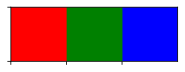

In [30]:
import seaborn as sns
import matplotlib.pyplot as plt
#графики в svg выглядят более четкими
%config InlineBackend.figure_format = 'svg'

import matplotlib as mpl
mpl.rcParams["xtick.bottom"] = True

flatui = ["red", "green", "blue"]
sns.palplot(sns.color_palette(flatui))

sns.set(font_scale = 1.5,
       style='white',
       palette=flatui,
       )

sns.set_style("ticks", {"xtick.bottom": True})

Распределение столкновений

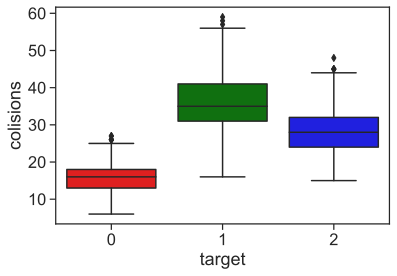

In [31]:
sns.boxplot(y="colisions", x="target",
            data=df1)

Распределение времени

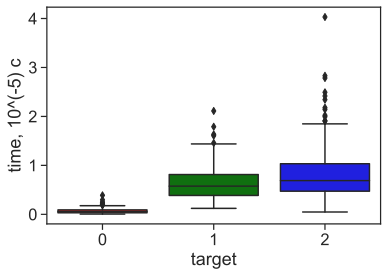

In [32]:
sns.boxplot(y="time, 10^(-5) c", x="target",
            data=df1)

Карта распрделений

In [33]:
df1['colisions'] = df1['colisions']/100
df1.rename(columns={'colisions': 'colisions, 10^2'}, inplace=True)

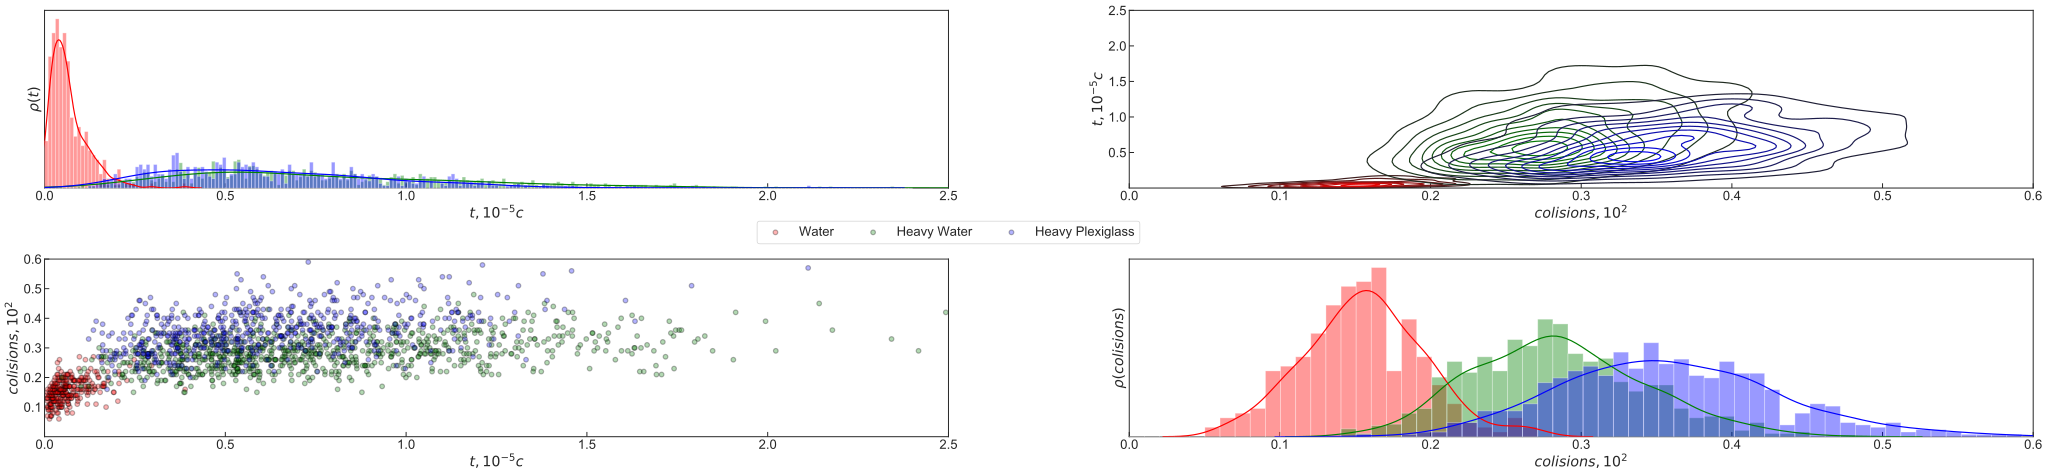

In [38]:
sns.set(font_scale = 1.5,
       style='white',
       )

g = sns.PairGrid(df1[['time, 10^(-5) c','colisions, 10^2', 'Material']],
                 hue='Material',
                 height=5.5,
                 palette= flatui,
                 despine = False,
                 hue_kws={
                     "marker": ["o", "o", "o"]
                 })

g.map_diag(sns.distplot, norm_hist = True, bins = np.linspace(0.0, 2.4, num=(6*4*10), endpoint=True))
g.map_upper(sns.kdeplot, shade=False, shade_lowest=False)
g.map_lower(plt.scatter, s = 35, alpha=0.3, linewidth=1.5, edgecolor="black")
g.fig.set_size_inches(19*2, 4*2)


plt.legend(loc='upper center', bbox_to_anchor=(1, 1.25), ncol=3) #vertical legend

# Подписи к осям
g.axes[0,0].yaxis.set_label_text(r'$\rho (t) $')
g.axes[0,0].xaxis.set_label_text('$t, 10^{-5} c$')
g.axes[1,1].yaxis.set_label_text(r'$\rho (colisions) $')
g.axes[1,1].xaxis.set_label_text('$colisions, 10^{2}$')
g.axes[1,0].yaxis.set_label_text('$colisions, 10^{2}$')
g.axes[1,0].xaxis.set_label_text('$t, 10^{-5} c$')
g.axes[0,1].yaxis.set_label_text('$t, 10^{-5} c$')
g.axes[0,1].xaxis.set_label_text('$colisions, 10^{2}$')

# Тики видны на y
g.axes[0,0].yaxis.set_tick_params(labelleft=False)
g.axes[1,1].yaxis.set_tick_params(labelleft=False)
g.axes[1,0].yaxis.set_tick_params(labelleft=True, bottom = True, direction = 'in')
g.axes[0,1].yaxis.set_tick_params(labelleft=True, bottom = True, direction = 'in')

# Тики видны на x
g.axes[0,0].xaxis.set_tick_params(labelleft=True, bottom = True, direction = 'in')
g.axes[1,1].xaxis.set_tick_params(labelleft=True, bottom = True, direction = 'in')
g.axes[1,0].xaxis.set_tick_params(labelleft=True, bottom = True, direction = 'in')
g.axes[0,1].xaxis.set_tick_params(labelleft=True, bottom = True, direction = 'in')

#Лимиты тиков на x
g.axes[1,0].set_xlim(0, 2.5)
g.axes[0,1].set_xlim(0, 0.6)

#Лимиты тиков на y
g.axes[1,0].set_ylim(0.00001, 0.6)
g.axes[0,0].set_ylim(0.00001, 2.5)

plt.subplots_adjust(hspace=0.4, wspace=0.2)
plt.savefig("desck.png")

# 4. Классификация DL #

## 4.1 Подготовка тренировочной и тестовой выборок ##

In [ ]:
from sklearn import model_selection
from sklearn import metrics
from sklearn import linear_model

In [ ]:
train_data, test_data, train_labels, test_labels = model_selection.train_test_split(
    df1[['time, 10^(-5) c', 'colisions, 10^2']], df1[['target']],
    test_size = 0.3, random_state = 0)

Посмотрим что из себя представляет тестовая выборка

In [ ]:
train_data

Сравним тестовую и обучающую выборки с исходным набором данных

In [ ]:
display(df1.describe())
display(test_data.describe())
display(train_data.describe())

Сравним частоту попадания каждого класса в исходном наборе, тестовой и тренировочной выборках

In [ ]:
display(df1['target'].value_counts(normalize=True))
display(test_labels['target'].value_counts(normalize=True))
display(train_labels['target'].value_counts(normalize=True))

## 4.2 Метрики точности ##

Precision (точность) можно интерпретировать как долю объектов, названных классификатором положительными и при этом действительно являющимися положительными (Реально Water из всех определенных Water):

\begin{align*} precision = {\frac{TP}{TP+FP}} \end{align*}

Recall (полнота) показывает, какую долю объектов положительного класса из всех объектов положительного класса нашел алгоритм (Сколько Water определено как Water):

\begin{align*} recall = {\frac{TP}{TP+FN}} \end{align*}

## 4.3 Метод обратного распространения ошибки ##

### Один нейрон ###

\begin{align*} y = f(w \cdot x + b) \end{align*}

\begin{align*} w = (0, 1) \end{align*}

\begin{align*} x = (2, 3) \end{align*}

\begin{align*} b = 4 \end{align*}

\begin{align*} (w \cdot x)+b = ((w_{1} * x_{1})+(w_{2} * x_{2}))+b = 0*2+1*3+4=7 \end{align*}

###  Функция активации ###

\begin{align*} y=f(x)=\frac{1}{1+e^{-x}} \end{align*}

### Объединим 2 нейрона в одну сеть ###

\begin{align*} h1=h2 = f(w \cdot x + b) \end{align*}

\begin{align*} o_{1} = f(w \cdot(h1, h2) + b) \end{align*}

### Тренировка нейронной сети ###

\begin{align*} L = L(w1,w2,w3,w4,w5,w6,b1,b2,b3) \end{align*}

\begin{align*} L = MSE = \frac{1}{n} \sum^{n}_{i=1} ({y_{true}-y_{pred}})^{2} \end{align*}

\begin{align*} y_{pred} = o1 = f(w5h1+w6h2+b3) \end{align*}

\begin{align*} h1 = f(w1 x1 + w2 x2 + b1) \end{align*}

\begin{align*} h2 = f(w3 x1 + w4 x2 + b2) \end{align*}

\begin{align*}
\frac{\partial L}{\partial w1} = 
\frac{\partial L}{\partial y_{pred}} *
\frac{\partial y_{pred}}{\partial h1} *
\frac{\partial h1}{\partial w1}
\end{align*}

\begin{align*}
1. \frac{\partial L}{y_{pred}}
\end{align*}

\begin{align*}
2. \frac{\partial L}{\partial h1} = 
\frac{\partial L}{\partial y_{pred}} *
\frac{\partial y_{pred}}{\partial h1}
\end{align*}

\begin{align*} \frac{\partial y_{pred}}{\partial h1} =
w5*f^\prime (w5h1+w6h2+b3)
\end{align*}

\begin{align*} f(x) = \frac{1}{1+e^{-x}} \end{align*}

\begin{align*} f^{\prime}(x) = \frac{e^{-x}}{(1+e^{-x})^{2}}
= f(x) * (1-f(x)) \end{align*}

\begin{align*} 3.
\frac{\partial L}{\partial w1} = 
\frac{\partial L}{\partial y_{pred}} *
\frac{\partial y_{pred}}{\partial h1} *
\frac{\partial h1}{\partial w1}
\end{align*}

\begin{align*} \frac{\partial h1}{\partial w1} =
x1*f^\prime (w1x1+w2x2+b1)
\end{align*}

Эта система подсчета частных производных при работе в обратном порядке известна, как метод обратного распространения ошибки, или backprop

\begin{align*}
w1 = w1 - \eta
\frac{\partial L}{\partial w1}
\end{align*}

Если $ \frac{\partial L}{\partial w1} $ положительная, w1 уменьшается, что приведет к уменьшению L

Если $ \frac{\partial L}{\partial w1} $ отрицательна, w1 увеличится, что приведет к уменьшению L

Если мы применим это на каждый вес и смещение в сети, потеря будет постепенно снижаться, а показатели сети сильно улучшатся

## 4.4 Scikit learn Perceptron

In [ ]:
from sklearn.linear_model import Perceptron as skPerceptron

In [ ]:
sk_perceptron = skPerceptron(random_state=0)
sk_perceptron.fit(train_data, train_labels)

In [ ]:
from sklearn import metrics

In [ ]:
model_predictions_sk_perceptron = sk_perceptron.predict(test_data)
print(metrics.accuracy_score(test_labels, model_predictions_sk_perceptron))
print(metrics.classification_report(test_labels, model_predictions_sk_perceptron))

In [ ]:
new_df = test_data
new_df['target'] = test_labels

new_df_0 = new_df
new_df_1 = new_df
new_df_2 = new_df

new_df_0 = new_df_0.drop(new_df_0[new_df_0.target != 0].index)
new_df_1 = new_df_1.drop(new_df_1[new_df_1.target != 1].index)
new_df_2 = new_df_2.drop(new_df_2[new_df_2.target != 2].index)

In [ ]:
error = [] # 1, если ошибка, 0 если правильно
time = []
colisions = []

np_test_labels = test_labels['target'].to_numpy()
np_test_time = test_data['time, 10^(-5) c'].to_numpy()
np_test_colisions = test_data['colisions, 10^2'].to_numpy()

for i in range(len(np_test_labels)):
    if np_test_labels[i] == model_predictions_sk_perceptron[i]:
        error.append(0)
    else:
        error.append(1)
        
for i in range(len(error)):
    if error[i] == 1:
        time.append(np_test_time[i])
        colisions.append(np_test_colisions[i]) 

In [ ]:
import matplotlib.pyplot as plt

from matplotlib.colors import ListedColormap
colors = ListedColormap(['red', 'green','blue'])

fig = plt.figure(figsize=(12,16))

#  Заголовок области Figure:
fig.suptitle('Perceptron sklearn',
             y= 0.93,
             fontsize = 20)

plt.subplots_adjust(wspace=0.15, hspace=0.2)

ax_1 = fig.add_subplot(3, 2, 1)
ax_2 = fig.add_subplot(3, 2, 4)
ax_3 = fig.add_subplot(3, 2, 3)
ax_4 = fig.add_subplot(3, 2, 2)

ax_1.set_xlim(0, 3)
ax_1.set_ylim(0, 0.7)
ax_2.set_xlim(0, 3)
ax_2.set_ylim(0, 0.7)
ax_3.set_xlim(0, 3)
ax_3.set_ylim(0, 0.7)
ax_4.set_xlim(0, 3)
ax_4.set_ylim(0, 0.7)

ax_1.set(title = 'Разделяющая поверхность')
def get_grid():
    x_min, x_max = 0, 4
    y_min, y_max = 0, 1
    return np.meshgrid(np.arange(x_min, x_max, 0.025),
                         np.arange(y_min, y_max, 0.025))
xx, yy = get_grid()
predicted = sk_perceptron.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
ax_1.pcolormesh(xx, yy, predicted, cmap=colors)
ax_1.scatter(test_data['time, 10^(-5) c'], test_data['colisions, 10^2'], c=test_labels['target'], s=15,
             cmap=colors, edgecolors='black', linewidth=1.5)
ax_1.set_ylabel('colisions, 10^2')
ax_1.set_xlabel('time, 10^(-5) c')


ax_2.set(title = 'Тестовый набор')
ax_2.scatter(new_df_0['time, 10^(-5) c'], new_df_0['colisions, 10^2'], c='red',
               s = 15, edgecolors = 'black', linewidths = 1, alpha = 0.5, label = 'Water')
ax_2.scatter(new_df_1['time, 10^(-5) c'], new_df_1['colisions, 10^2'], c='green',
               s = 15, edgecolors = 'black', linewidths = 1, alpha = 0.5, label = 'Heavy Plexiglass')
ax_2.scatter(new_df_2['time, 10^(-5) c'], new_df_2['colisions, 10^2'], c='blue',
               s = 15, edgecolors = 'black', linewidths = 1, alpha = 0.5, label = 'Heavy Water')
ax_2.set_ylabel('colisions, 10^2')
ax_2.set_xlabel('time, 10^(-5) c')
ax_2.set_title('Тестовый набор')
ax_2.set_xlim(left = 0)
ax_2.legend()

ax_3.set(title = 'Модель')
ax_3.scatter(test_data['time, 10^(-5) c'], test_data['colisions, 10^2'], c=model_predictions_sk_perceptron, cmap=colors, s = 15
            , edgecolors = 'black', linewidths = 1, alpha = 0.5)
ax_3.set_ylabel('colisions, 10^2')
ax_3.set_xlabel('time, 10^(-5) c')
ax_3.set_title('Модель')
ax_3.set_xlim(left = 0)

ax_4.set(title = 'Ошибки')
ax_4.pcolormesh(xx, yy, predicted, cmap=colors)
ax_4.scatter(time, colisions, c='yellow',
               s = 15, edgecolors = 'black', linewidths = 1, alpha = 0.5)
ax_4.set_ylabel('colisions, 10^2')
ax_4.set_xlabel('time, 10^(-5) c')
ax_4.set_title('Ошибки')
ax_4.set_xlim(left = 0)
ax_4.set_xlim(right = 3)
ax_4.set_ylim(bottom = 0)
ax_4.set_ylim(top = 0.7)
fig.savefig('мой график1')

plt.subplots_adjust(wspace=0.3, hspace=0.3)
plt.show()

print(metrics.classification_report(test_labels, model_predictions_sk_perceptron))

## 4.5 PyTorch Азы

In [ ]:
import torch

torch.HalfTensor      # 16 бит, с плавающей точкой
torch.FloatTensor     # 32 бита,  с плавающей точкой
torch.DoubleTensor    # 64 бита, с плавающей точкой

torch.ShortTensor     # 16 бит, целочисленный, знаковый
torch.IntTensor       # 32 бита, целочисленный, знаковый
torch.LongTensor      # 64 бита, целочисленный, знаковый

torch.CharTensor      # 8 бит, целочисленный, знаковый
torch.ByteTensor      # 8 бит, целочисленный, беззнаковый

Создание Тензора

In [ ]:
a = torch.FloatTensor([1, 2])
a

In [ ]:
a.shape

In [ ]:
b = torch.FloatTensor([[1,2,3], [4,5,6]])
b

In [ ]:
b.shape

In [ ]:
x = torch.IntTensor(3, 2).zero_()
x

Операторы

Сложение

In [ ]:
a = torch.FloatTensor([[1, 2, 3], [10, 20, 30], [100, 200, 300]])
b = torch.FloatTensor([[-1, -2, -3], [-10, -20, -30], [100, 200, 300]])

In [ ]:
a.add(b)

Вычитание

In [ ]:
a.sub(b)

Умножение поэлементное

In [ ]:
a.mul(b)

Деление поэлементное

In [ ]:
a.div(b)

Операторы сравнения

In [ ]:
a == b

In [ ]:
a != b

In [ ]:
a < b

In [ ]:
a > b

Стандартные функции как в numpy

In [ ]:
a.log()

In [ ]:
a.sum()

In [ ]:
a.mean()

По осям:

In [ ]:
a

In [ ]:
a.sum(0)

In [ ]:
a.sum(1)

In [ ]:
a.max()

In [ ]:
a.max(0)

Матричные операции

Транспонирование

In [ ]:
a

In [ ]:
a.t()

Скалярное произведение векторов

In [ ]:
a = torch.FloatTensor([1, 2, 3, 4, 5, 6])
b = torch.FloatTensor([-1, -2, -4, -6, -8, -10])

In [ ]:
a.dot(b)

In [ ]:
a @ b

Матричное умножение 

In [ ]:
a = torch.FloatTensor([[1, 2, 3], [10, 20, 30], [100, 200, 300]])
b = torch.FloatTensor([[-1, -2, -3], [-10, -20, -30], [100, 200, 300]])

In [ ]:
a

In [ ]:
b

In [ ]:
a.mm(b)

In [ ]:
a @ b

In [ ]:
a = torch.FloatTensor([[1, 2, 3], [10, 20, 30], [100, 200, 300]])
b = torch.FloatTensor([[-1], [-10], [100]])

In [ ]:
print(a.shape, b.shape)

In [ ]:
a.mm(b)

In [ ]:
b.view(-1)

Перевод из numpy в pytorch

In [ ]:
import numpy as np

a = np.random.rand(3, 3)
a

In [ ]:
b = torch.from_numpy(a)
b

a и b в этом случае будут использовать одно и то же хранилище данных, то есть измение одного тензора будет менять и другой

In [ ]:
b -= b
b

In [ ]:
a

Перевод из pytorch в numpy

In [ ]:
a = torch.FloatTensor(2, 3)

In [ ]:
a

In [ ]:
x = a.numpy()
x

## 4.6 CUDA

In [ ]:
x = torch.FloatTensor(1024, 1024).uniform_()
x

In [ ]:
x.is_cuda

In [ ]:
x = x.cuda()

In [ ]:
x.is_cuda

In [ ]:
a = torch.FloatTensor(10000, 10000).uniform_()
b = torch.FloatTensor(10000, 10000).uniform_()
c = a.cuda().mul(b.cuda()).cpu()

Сравнение времени перемножения

In [ ]:
a.is_cuda

In [ ]:
b.is_cuda

In [ ]:
from datetime import datetime
import time

In [ ]:
start_time = datetime.now()
c = a.mul(b)
print(datetime.now() - start_time)

In [ ]:
a = a.cuda()
a.is_cuda

In [ ]:
b = b.cuda()
b.is_cuda

In [ ]:
start_time = datetime.now()
c = a.mul(b)
print(datetime.now() - start_time)

## 4.7 Нейронная сеть на pytorch

In [ ]:
N = 100
D = 2
K = 3
X = np.zeros((N * K, D))
y = np.zeros(N * K, dtype='uint8')

In [ ]:
X.shape

In [ ]:
y.shape

In [ ]:
train_data.head(2)

In [ ]:
train_data.shape

In [ ]:
train_labels.head(2)

In [ ]:
train_labels.shape

In [ ]:
X = train_data.to_numpy()
y = train_labels['target'].to_numpy()

In [ ]:
y

In [ ]:
X = torch.autograd.Variable(torch.FloatTensor(X))
y = torch.autograd.Variable(torch.LongTensor(y.astype(np.int64)))

In [ ]:
print(X.data.shape, y.data.shape)

In [ ]:
# пример взят из официального туториала: 
# https://pytorch.org/tutorials/beginner/pytorch_with_examples.html

# N - размер батча (batch_size, нужно для метода оптимизации); 
# D_in - размерность входа (количество признаков у объекта);
# H - размерность скрытых слоёв; 
# D_out - размерность выходного слоя (суть - количество классов)
N, D_in, H, D_out = 10, 2, 100, 3

# Use the nn package to define our model and loss function.
two_layer_net = torch.nn.Sequential(
    torch.nn.Linear(D_in, H),
    torch.nn.ReLU(),
    torch.nn.Linear(H, D_out),
)

loss_fn = torch.nn.CrossEntropyLoss(size_average=False)

learning_rate = 5e-4
optimizer = torch.optim.SGD(two_layer_net.parameters(), lr=learning_rate)
for t in range(500):
    # forward
    y_pred = two_layer_net(X)

    # loss
    loss = loss_fn(y_pred, y)
    print('{} {}'.format(t, loss.data))

    # ЗАНУЛЯЕМ!
    optimizer.zero_grad()

    # backward
    loss.backward()

    # ОБНОВЛЯЕМ! 
    optimizer.step()

In [ ]:
h = 0.02
x_min, x_max = X[:, 0].min(), X[:, 0].max()
y_min, y_max = X[:, 1].min(), X[:, 1].max()

xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
grid_tensor = torch.FloatTensor(np.c_[xx.ravel(), yy.ravel()])

Z = two_layer_net(torch.autograd.Variable(grid_tensor))
Z = Z.data.numpy()
Z = np.argmax(Z, axis=1)
Z = Z.reshape(xx.shape)

plt.figure(figsize=(10, 8))

plt.contourf(xx, yy, Z, cmap=plt.cm.rainbow, alpha=0.3)
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.rainbow)

plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())

plt.title('Игрушка дьявола', fontsize=15)
plt.xlabel('$x$', fontsize=14)
plt.ylabel('$y$', fontsize=14)
plt.show();